Neural Network: Linear Regression
===

**Autor:** Mateus de Jesus Mendes

# Introdução

O presente *Jupyter Notebook* tem por objetivo implementar em Python puro uma Rede Neural Linear de Camada Única Integralmente Conectada para regressão utilizando Programação Orientada a Objetos.

# Metodologia

### Importações

In [284]:
import random
import matplotlib.pyplot as plt

### Definições Globais

In [285]:
RANDOM_SEED = 88
random.seed(RANDOM_SEED)

### Funções Auxiliares

Funções secundárias utilizadas nas etapas principais da metodologia. 

##### **Produto Interno**

In [286]:
def dot(a, b):
    """
    Cálculo do produto interno dos casos:
    - Vetor-vetor
    - Matriz-vetor
    - Matriz-matriz
    
    ### Parâmetros
    - `a`/`b`: Vetor ou matriz.

    ### Retorna
    Float (escalar) para produto vetor-vetor / Lista (vetor) para produto matriz-vetor / Matriz (lista de listas) para produto matriz-matriz.
    """

    # Funções auxiliares de identificação
    def is_vector(x):
        return isinstance(x[0], (int, float))

    def is_matrix(x):
        return isinstance(x[0], list)

    # Produto vetor-vetor -> escalar
    if is_vector(a) and is_vector(b):
        if len(a) != len(b):
            raise ValueError("Vetores devem ter o mesmo comprimento.")
        
        s = 0
        for i in range(len(a)):
            s += a[i] * b[i]
        return s

    # Produto matriz-vetor -> vetor
    if is_matrix(a) and is_vector(b):
        n_rows = len(a)
        n_cols = len(a[0])

        if n_cols != len(b):
            raise ValueError("Dimensões incompatíveis para produto matriz-vetor.")

        result = []
        for i in range(n_rows):
            sum = 0
            for j in range(n_cols):
                sum += a[i][j] * b[j]
            result.append(sum)
        return result

    # Produto matriz-matriz -> matriz
    if is_matrix(a) and is_matrix(b):
        n_rows_a = len(a)
        n_cols_a = len(a[0])
        n_rows_b = len(b)
        n_cols_b = len(b[0])

        if n_cols_a != n_rows_b:
            raise ValueError("Dimensões incompatíveis para produto matriz-matriz.")

        result = []
        for i in range(n_rows_a):
            row = []
            for j in range(n_cols_b):
                sum = 0
                for k in range(n_cols_a):
                    sum += a[i][k] * b[k][j]
                row.append(sum)
            result.append(row)
        return result

    # Caso inválido
    raise TypeError("Entradas devem ser vetores ou matrizes válidas.")

##### ***Holdout***

In [287]:
def holdout(X, y, train_size=0.8):
    """
    Realiza a partição *holdout* de um conjunto de dados supervisionado
    em subconjuntos de treinamento e teste.

    A função separa aleatoriamente o conjunto de dados original
    D = {(x_i, y_i)}_{i=1}^{N} em dois subconjuntos disjuntos:
    um conjunto de treinamento D_train e um conjunto de teste D_test,
    respeitando a proporção especificada por `train_size`.

    ### Parâmetros
    - `X` (list[list[float]]): Conjunto de N vetores de entrada, X = {x₁, x₂, …, x_N}, com x_i ∈ ℝᵈ.

    - `y` (list[float]): Vetor dos valores alvo associados às instâncias de entrada, y = (y₁, y₂, …, y_N).

    - `train_size` (float, opcional): Fração do conjunto de dados destinada ao treinamento, com 0 < `train_size` < 1.

    ### Retorno
    tuple[list, list, list, list]

        Tupla `(X_train, X_test, y_train, y_test)`, onde:
     - `X_train`: subconjunto dos vetores de entrada utilizados no treinamento;
     - `X_test`: subconjunto dos vetores de entrada utilizados na avaliação;
     - `y_train`: valores alvo correspondentes ao conjunto de treinamento;
     - `y_test`: valores alvo correspondentes ao conjunto de teste.

    ### Observações
    - A partição é realizada por embaralhamento aleatório dos índices,
      caracterizando um *holdout* simples.
    - Não há estratificação em relação à variável alvo.
    - Não há controle explícito de *seed*, o que implica não reprodutibilidade
      entre execuções distintas.
    - A função preserva a correspondência entre instâncias de entrada e seus
      respectivos valores alvo.
    """

    if not 0 < train_size < 1:
        raise ValueError('train_size deve estar no intervalo (0, 1).')
    
    if len(X) != len(y):
        raise ValueError('X e y devem ter o mesmo comprimento.')

    n = len(X)
    indices = list(range(n))
    random.shuffle(indices)

    split = int(n * train_size)

    train_idx = indices[:split]
    test_idx = indices[split:]

    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]

    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]

    return X_train, X_test, y_train, y_test

### 0. Geração / Leitura de Dados

O conjunto de dados é gerado a partir do modelo linear com ruído aditivo:
$$
y_i = \mathbf{w}_{\text{true}}^{\top}\mathbf{x}_i + b_{\text{true}} + \varepsilon_i,
\quad i = 1, \dots, N
$$

Em que:
- $\mathbf{x}_i \in \mathbb{R}^d$: Vvetor de *features* da $i$-ésima amostra.
- $\mathbf{w}_{\text{true}} \in \mathbb{R}^d$: Vetor de pesos verdadeiro.
- $b_{\text{true}} \in \mathbb{R}$: Viés verdadeiro.
- $\varepsilon_i \sim \mathcal{N}(0, 1)$: Ruído Gaussiano Aditivo Independente.

Os vetores $\mathbf{x}_i$ também são amostrados de uma Distribuição Normal Padrão:
$$
\mathbf{x}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

In [288]:
class SyntheticLinearData:
    def __init__(self, n_samples, n_features):
        self.n_samples = n_samples
        self.n_features = n_features
    
    def generate(self):
        self.w_true = [random.gauss() for _ in range(self.n_features)]
        self.b_true = random.uniform(0, 9)

        X, y = [], []

        for _ in range(self.n_samples):
            x_i = [random.gauss() for _ in range(self.n_features)]
            noise = random.gauss()
            y_i = dot(self.w_true, x_i) + self.b_true + noise

            X.append(x_i)
            y.append(y_i)

        return X, y

### 1. Definição do Modelo

O modelo considerado corresponde a uma transformação afim totalmente conectada, definida por:
$$
\hat{y} = \mathbf{w}^{\top}\mathbf{x} + b
$$

Em que:
- $\mathbf{x} \in \mathbb{R}^d$: Vetor de entrada.
- $\mathbf{w} \in \mathbb{R}^d$: Vetor de pesos treináveis.
- $b \in \mathbb{R}$: Termo de viés.

Os parâmetros $\mathbf{w}$ e $b$ são inicializados aleatoriamente a partir de uma distribuição uniforme simétrica de pequeno suporte em torno de zero:
$$
w_j \sim \mathcal{U}(-\varepsilon, \varepsilon),
\quad
b \sim \mathcal{U}(-\varepsilon, \varepsilon),
\quad
\varepsilon = 10^{-3}
$$

Essa abordagem tem por objetivo garantir estabilidade numérica e dinâmica adequada do gradiente nas etapas iniciais do treinamento.

In [289]:
class LinearRegressor:
    def __init__(self, n_features):
        self.n_features = n_features
        self.w = [0.0] * n_features
        self.b = 0.0
    
    def forward(self, X):
        return [dot(self.w, x) + self.b for x in X]

    def predict(self, X):
        return self.forward(X)

### 2. *Forward Pass*

Dado um conjunto de $N$ vetores de entrada, o *forward pass* do modelo linear consiste na aplicação de uma transformação afim independente a cada instância:
$$
\hat{y}_i = \mathbf{w}^{\top}\mathbf{x}_i + b, \quad i = 1,\,\cdots,\,N
$$

Em forma vetorial:
$$
\hat{\mathbf{y}} = \mathbf{Xw} + b
$$

Em que:
- $X \in \mathbb{R}^{N \times d}$: Matriz de entradas.
- $\mathbf{w} \in \mathbb{R}^{d}$: Vetor de pesos do modelo.
- $b \in \mathbb{R}$: Termo de viés.
- $\hat{\mathbf{y}} \in \mathbb{R}^{N}$: Vetor de saídas pré-ativação (*logits*).

Cada saída $\hat{y}_i$ corresponde à predição linear do modelo para a $i$-ésima amostra, sem aplicação de função de ativação não linear.

**Observações conceituais**
- Este *forward pass* implementa exatamente uma camada totalmente conectada linear, sendo matematicamente equivalente à regressão linear multivariada.
- A ausência de função de ativação implica que o espaço de hipóteses do modelo é estritamente afim.
- A independência entre as amostras reflete-se na forma escalar da operação aplicada a cada $\mathbf{x}_i$.

### 3. *Loss Function*

A verossimilhança das predições do modelo é avaliada por meio do Erro Quadrático Médio (*Mean Squared Error – MSE*), definido como:

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N}  \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Em que:
- $\mathbf{y} \in \mathbb{R}^{N}$: Vetor de valores verdadeiros (*targets*).
- $\hat{\mathbf{y}} \in \mathbb{R}^{N}$: Vetor de predições do modelo.
- $N$: Número total de amostras.

O MSE penaliza erros grandes de forma quadrática, tornando-se particularmente sensível a desvios significativos entre predição e valor real.

**Observações Conceituais**
- A função de perda é convexa em relação a $\hat{\mathbf{y}}$ e, por composição, em relação aos parâmetros $\mathbf{w}$ e $b$ de modelos lineares.
- É diferenciável em todo o domínio, o que a torna apropriada para métodos de otimização baseados em gradiente.
- Para Ruído Gaussiano Aditivo, a minimização do MSE equivale à estimação de máxima verossimilhança dos parâmetros do modelo.

In [290]:
class MeanSquaredError:
    def __call__(self, y_true, y_pred):
        N = len(y_true)
        return sum((y_true[i] - y_pred[i])**2 for i in range(N)) / N

### 4. *Backward Pass*

O *backward pass* do modelo linear consiste na avaliação explícita dos gradientes da função de perda em relação aos parâmetros treináveis. 

Considerando o modelo:

$$
\hat{y}_i = \mathbf{w}^{\top}\mathbf{x}_i + b
$$

E a função de perda Erro Quadrático Médio:

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Os gradientes analíticos são dados por:

$$
\nabla_{\mathbf{w}} \mathcal{L} = \frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)\mathbf{x}_i, \qquad \frac{\partial \mathcal{L}}{\partial b} = 
\frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)
$$

Essas expressões resultam diretamente da aplicação da regra da cadeia e constituem a base para métodos de otimização por gradiente descendente.

**Observações Conceituais**
- Cada termo $(\hat{y}_i - y_i)$ representa o erro de predição da $i$-ésima amostra.
- O gradiente em relação aos pesos é uma soma ponderada dos vetores de entrada, escalada pelo erro.
- O gradiente em relação ao viés corresponde à média dos erros, refletindo um deslocamento global da função afim.
- A normalização por $N$ garante que a magnitude do gradiente seja independente do tamanho do conjunto de dados.

In [291]:
class MSEGradient:
    def backward(self, X, y_true, y_pred):

        N = len(X)
        d = len(X[0])

        grad_w = [0.0] * d
        grad_b = 0.0

        for i in range(N):
            error = y_true[i] - y_pred[i]

            for j in range(d):
                grad_w[j] += -2 * error * X[i][j]
            
            grad_b += -2 * error
        
        grad_w =[grad_w[k] / N for k in range(d)]
        grad_b /= N

        return grad_w, grad_b

### 5. *Gradient Descent*

A etapa de otimização do modelo é realizada por meio do Gradiente Descendente, que atualiza iterativamente os parâmetros treináveis na direção oposta ao gradiente da função de perda. Para um modelo linear, a regra de atualização é dada por:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla_{\mathbf{w}} \mathcal{L}, \qquad b^{(t+1)} = b^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial b}
$$

Em que:
- $\eta > 0$ é a taxa de aprendizado (*learning rate*);
- $\nabla_{\mathbf{w}} \mathcal{L}$ e $\frac{\partial \mathcal{L}}{\partial b}$ são os gradientes computados no *backward pass*;
- $t$ denota a iteração de treinamento.

Essa atualização corresponde a um único passo de descida no espaço de parâmetros, com o objetivo de minimizar a função de perda.

**Observações Conceituais**
- O Gradiente Descendente explora o fato de que, em modelos lineares com MSE, a função de perda é convexa, assegurando convergência ao mínimo global sob escolha adequada de $\eta$.
- A magnitude da taxa de aprendizado controla o compromisso entre velocidade de convergência e estabilidade numérica.
- A ausência de *momentum* ou mecanismos adaptativos torna essa implementação conceitualmente transparente e didaticamente valiosa.

In [292]:
class GradientDescent:
    def __init__(self, lr):
        self.lr = lr

    def step(self, model, grad_w, grad_b):
        model.w = [model.w[j] -self.lr * grad_w[j] for j in range(len(model.w))]

        model.b -= self.lr * grad_b

### 6. *Training Loop*

O treinamento do modelo é realizado por meio de um *loop* iterativo de otimização baseada em gradiente, no qual os parâmetros do modelo são ajustados progressivamente para minimizar a função de perda Erro Quadrático Médio (MSE):
$$
\mathcal{L}(\mathbf{w}, b) = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - (\mathbf{w}^{\top}\mathbf{x}_i + b)\right)^2
$$

A cada época, o seguinte ciclo é executado:

1. Inicialização dos parâmetros $(\mathbf{w}, b)$ (realizada uma única vez).
2. *Forward pass* para obtenção das predições $\hat{\mathbf{y}}$.
3. Avaliação da perda $\mathcal{L}$.
4. *Backward pass* para cálculo analítico dos gradientes.
5. Atualização dos parâmetros via Gradiente Descendente.

De forma abstrata, o processo pode ser descrito como:

$$
(\mathbf{w}, b) \xleftarrow{\text{iterativamente}} \arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b), \quad \text{via Gradiente Descendente em modo batch}.
$$

O vetor `loss_log` armazena o valor da função de perda ao final de cada época, permitindo a análise da dinâmica de convergência do treinamento.

**Observações conceituais**
- O treinamento é realizado em modo *batch*, utilizando todo o conjunto de dados em cada iteração.
- Em modelos lineares com MSE, a função objetivo é convexa, garantindo convergência ao mínimo global sob escolha adequada da taxa de aprendizado.
- A ausência de *early stopping*, regularização ou validação torna o procedimento conceitualmente simples e transparente, favorecendo análise didática do comportamento do gradiente.

In [293]:
class Trainer:
    def __init__(self, model, loss_fn, loss_grad, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_grad = loss_grad
        self.optimizer = optimizer
    
    def fit(self, X, y, epochs):
        loss_log = []

        for _ in range(epochs):
            y_pred = self.model.forward(X)
            loss = self.loss_fn(y, y_pred)
            loss_log.append(loss)

            grad_w, grad_b = self.loss_grad.backward(X, y, y_pred)
            self.optimizer.step(self.model, grad_w, grad_b)

        return loss_log

# Teste

In [294]:
# Dados
data = SyntheticLinearData(1_000, 2)
X, y = data.generate()
X_train, X_test, y_train, y_test = holdout(X, y)

# Modelo
model = LinearRegressor(n_features=2)

# Componentes
loss_fn = MeanSquaredError()
loss_grad = MSEGradient()
optimizer = GradientDescent(lr=0.001)

# Treino
trainer = Trainer(model, loss_fn, loss_grad, optimizer)
loss_log = trainer.fit(X_train, y_train, epochs=10_000)

# Avaliação
train_loss = loss_log[-1]
test_loss = loss_fn(y_test, model.predict(X_test))
print(f'Desempenho (MSE) de teste do modelo: {test_loss}')

Desempenho (MSE) de teste do modelo: 0.9789565409999332


# Resultados

Comparação entre os parâmetros fundamentalmente verdadeiros definidos na geração dos dados sintéticos e os parâmetros estimados pelo modelo:

In [295]:
print("Parâmetros verdadeiros:")
print("w_true =", data.w_true)
print("b_true =", data.b_true)

print("\nParâmetros aprendidos:")
print("w_hat  =", model.w)
print("b_hat  =", model.b)

Parâmetros verdadeiros:
w_true = [-0.5183735347655064, 0.3892625131435465]
b_true = 8.121953879779781

Parâmetros aprendidos:
w_hat  = [-0.5157789924964914, 0.42087750182010275]
b_hat  = 8.075824447512753


Visualização da evolução da *loss* do modelo ao longo das épocas de treino:

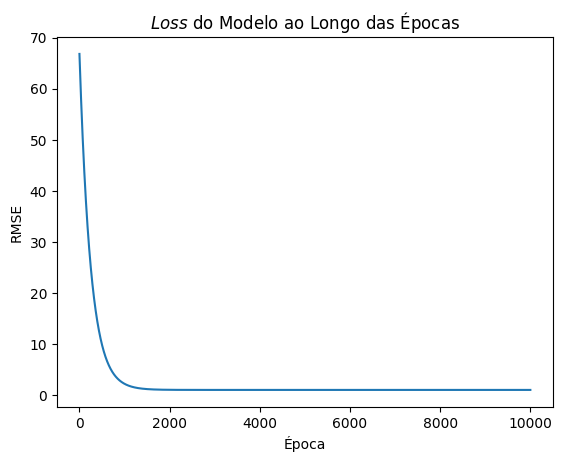

In [296]:
fig, ax = plt.subplots()

ax.plot(loss_log)

ax.set_title('$Loss$ do Modelo ao Longo das Épocas')
ax.set_ylabel('RMSE')
ax.set_xlabel('Época');

# Conclusão

Conclusões gerais sobre o modelo são idênticas àquelas desenvolvidas para a versão 1.0 da implementação.